# Passer Ratings: Hand Sizes

Hypothesis: Hand size affects average seasonal passer rating.

QB's are apparently meant to have hands above 9.25 inches.

In [1]:
import pandas as pd
import numpy as np
import mysql.connector
import sys
from datetime import datetime as dt
sys.path.append('..')

## Load

In [2]:
cnx = mysql.connector.connect(user='root', password='mOntie20!mysql', host='127.0.0.1', database='nfl')
sql = open('../sql/qb_season_ratings.sql', 'r').read()
df = pd.read_sql(sql, cnx)
df = df.loc[:,~df.columns.duplicated()][df['attempts']>50].set_index(['player','year'])

The dataset uses empty strings as missing values. We'll change that to NaN.

## Clean

In [5]:
df = df.apply(lambda x: x.replace('', np.nan))

# physical
df.loc[df['hand']<1, 'hand'] = np.nan
df['hand'] = df.groupby('player')['hand'].apply(lambda x: x.fillna(method='ffill'))
df.loc[df['height']<1, 'height'] = np.nan
df.loc[df['weight']<1, 'weight'] = np.nan
df.loc[df['arm']<1, 'arm'] = np.nan

# combine
df.loc[df['broad']<1, 'broad'] = np.nan
df.loc[df['cone']<1, 'cone'] = np.nan
df.loc[df['shuttle']<1, 'shuttle'] = np.nan 

df.describe()

,attempts,completions,yards,interceptions,TD,avg_rating,sack_rate,alt_rate,precip_rate,turf_rate,...,vertical,broad,shuttle,cone,arm,hand,dpos,start,jnum,dcp
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,...,1014.000000,528.000000,551.000000,539.000000,485.000000,515.00000,1014.000000,1014.000000,1014.000000,1014.000000
mean,346.623274,211.994083,2435.874753,9.706114,14.737673,80.376627,0.067296,0.030572,0.084831,0.423961,...,17.377712,111.323864,4.283013,7.121744,32.135309,9.59213,57.834320,2003.830375,3.279093,0.696252
std,197.733500,128.141549,1511.868073,5.688563,11.215744,15.095219,0.027190,0.094902,0.109693,0.269861,...,16.140787,6.963120,0.167032,0.229315,1.047378,0.46930,73.885134,7.164602,5.075347,1.101218
min,51.000000,18.000000,167.000000,0.000000,0.000000,16.700000,0.000000,0.000000,0.000000,0.000000,...,0.000000,96.000000,3.900000,6.660000,28.500000,8.25000,0.000000,1985.000000,0.000000,0.000000
25%,160.250000,93.000000,1020.750000,5.000000,5.000000,71.025000,0.048425,0.000000,0.000000,0.200000,...,0.000000,106.000000,4.175000,6.950000,31.250000,9.26800,1.000000,1999.000000,0.000000,0.000000
50%,341.500000,204.000000,2321.500000,9.000000,12.000000,81.050000,0.064000,0.000000,0.058800,0.333300,...,26.500000,111.000000,4.280000,7.110000,32.000000,9.50000,22.000000,2004.000000,0.000000,0.000000
75%,525.750000,320.000000,3705.750000,14.000000,22.000000,90.600000,0.082775,0.000000,0.133300,0.666700,...,32.500000,116.000000,4.380000,7.210000,32.875000,9.87500,93.000000,2009.000000,7.000000,1.000000
max,787.000000,541.000000,6404.000000,30.000000,60.000000,121.000000,0.194000,0.750000,0.750000,1.000000,...,39.000000,127.000000,4.780000,7.800000,35.000000,10.87500,285.000000,2019.000000,19.000000,5.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1014 entries, ('DB-3800', 2011) to ('SW-2400', 2000)
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   attempts       1014 non-null   float64
 1   completions    1014 non-null   float64
 2   yards          1014 non-null   float64
 3   interceptions  1014 non-null   float64
 4   TD             1014 non-null   float64
 5   avg_rating     1014 non-null   float64
 6   sack_rate      1014 non-null   float64
 7   alt_rate       1014 non-null   float64
 8   precip_rate    1014 non-null   float64
 9   turf_rate      1014 non-null   float64
 10  wind_rate      1014 non-null   float64
 11  away_rate      1014 non-null   float64
 12  temp           1014 non-null   float64
 13  fname          1014 non-null   object 
 14  lname          1014 non-null   object 
 15  pname          1014 non-null   object 
 16  pos1           1014 non-null   object 
 17  pos2           1014 non

Lets load in combine data we scraped outside of this notebook.

In [3]:
def fill(group, cols, data):
    group = group.reset_index(-1)
    for col in cols:
        if col not in group.columns:
            group[col] = np.nan
        group[col] = group[col].fillna(data[col])
    group = group.set_index('year', append=True)
    return group

In [6]:
today = dt.now().strftime('%y%m%d')
qb_combine = pd.read_csv(f'../data/combine_qb_{today}.csv', index_col=0)
cols = qb_combine.drop(['fname','lname'], axis=1).columns.values
qb_combine

,fname,lname,arm,hand,shuttle,cone,broad,wonderlic,ball_speed
player,,,,,,,,,
AB-2900,Aaron,Brooks,32.000,9.500,4.29,7.52,120.0,17.0,NaN
AF-0300,A.J.,Feeley,NaN,NaN,4.16,NaN,NaN,NaN,NaN
AS-1400,Akili,Smith,32.250,9.750,4.29,6.99,114.0,26.0,NaN
AS-1600,Alex,Smith,31.750,9.375,3.97,6.82,113.0,40.0,NaN
AV-0200,Alex,Van Pelt,31.880,9.750,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
TS-2600,Troy,Smith,NaN,8.250,NaN,NaN,NaN,NaN,NaN
TT-0900,Tyler,Thigpen,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VT-0200,Vinny,Testaverde,33.500,10.000,NaN,NaN,NaN,NaN,NaN


Now fill the values in the dataframe

In [7]:
df = df.groupby('player').apply(lambda x: fill(x, cols, qb_combine))

In [8]:
df.loc['AB-2qb900', 'hand']

year
2001    9.5
2004    9.5
2002    9.5
2003    9.5
2005    9.5
2000    9.5
2006    9.5
Name: hand, dtype: float64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1014 entries, ('DB-3800', 2011) to ('SW-2400', 2000)
Data columns (total 40 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   attempts       1014 non-null   float64
 1   completions    1014 non-null   float64
 2   yards          1014 non-null   float64
 3   interceptions  1014 non-null   float64
 4   TD             1014 non-null   float64
 5   avg_rating     1014 non-null   float64
 6   sack_rate      1014 non-null   float64
 7   alt_rate       1014 non-null   float64
 8   precip_rate    1014 non-null   float64
 9   turf_rate      1014 non-null   float64
 10  wind_rate      1014 non-null   float64
 11  away_rate      1014 non-null   float64
 12  temp           1014 non-null   float64
 13  fname          1014 non-null   object 
 14  lname          1014 non-null   object 
 15  pname          1014 non-null   object 
 16  pos1           1014 non-null   object 
 17  pos2           83 non-n

In [104]:
df_clean = df.loc[:,['attempts','avg_rating','sack_rate','alt_rate','precip_rate','turf_rate','wind_rate','away_rate','temp','height','arm','start','hand']].reset_index()
df_clean

,player,year,attempts,avg_rating,sack_rate,alt_rate,precip_rate,turf_rate,wind_rate,away_rate,temp,height,arm,start,hand
0,DB-3800,2011,763.0,110.6,0.0365,0.0000,0.0000,0.7222,2.333333,0.5000,68.944444,72.0,31.250,2001,10.000
1,PM-0200,2013,787.0,111.7,0.0223,0.5263,0.0526,0.2632,7.526316,0.4211,57.578947,77.0,31.500,1998,10.130
2,EM-0200,2011,752.0,95.1,0.0493,0.0000,0.1000,0.7500,7.850000,0.5500,57.550000,77.0,30.750,2004,9.750
3,TB-2300,2011,722.0,104.8,0.0462,0.0526,0.0000,0.6316,7.842105,0.4211,55.000000,76.0,32.750,2000,9.380
4,MR-2500,2016,632.0,119.9,0.0661,0.0526,0.0526,0.7368,2.052632,0.4211,68.611111,77.0,32.375,2008,9.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,KD-0600,2005,56.0,45.1,0.0508,0.0000,0.2000,0.2000,4.200000,0.4000,61.600000,73.0,32.880,1998,8.000
1010,AW-2100,2000,53.0,31.7,0.1846,0.0000,0.0000,0.5000,11.250000,0.5000,49.750000,73.0,31.500,2000,9.500
1011,WG-0750,2019,52.0,33.2,0.1034,0.0000,0.0000,0.5000,4.500000,0.5000,66.500000,74.0,31.500,2019,9.375
1012,HB-0400,2002,51.0,27.2,0.0714,0.0000,0.0000,0.4000,8.000000,0.8000,50.200000,72.0,NaN,2002,NaN


In [105]:
def average(group):
    row = {}
    for i, col in group.iteritems():
        if i!='player':
            row[i] = [col.mean()]
    row['seasons'] = [group['year'].max()-group['start'].min()]
    row.pop('year')
    new_group = pd.DataFrame.from_dict(row, orient='columns')
    return new_group

In [106]:
df_clean = df_clean.groupby('player').apply(average).reset_index(-1, drop=True).drop('arm', axis=1).dropna()

In [107]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, AB-2900 to ZM-0150
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   attempts     196 non-null    float64
 1   avg_rating   196 non-null    float64
 2   sack_rate    196 non-null    float64
 3   alt_rate     196 non-null    float64
 4   precip_rate  196 non-null    float64
 5   turf_rate    196 non-null    float64
 6   wind_rate    196 non-null    float64
 7   away_rate    196 non-null    float64
 8   temp         196 non-null    float64
 9   height       196 non-null    float64
 10  start        196 non-null    float64
 11  hand         196 non-null    float64
 12  seasons      196 non-null    int64  
dtypes: float64(12), int64(1)
memory usage: 21.4+ KB


## Pair

We now have the missing hand sizes, it's time to select those with small hands and pair them with those with big hands.

In [122]:
big = np.percentile(df_clean['hand'], q=66) # top 3rd
small = np.percentile(df_clean['hand'], q=33) # bottom 3rd
df_small = df_clean[df_clean['hand']<=small]
df_big = df_clean[df_clean['hand']>=big]
print(len(df_big),len(df_small))

82 70


In [124]:
def get_mask(data, row, dsack=0.1, dalt=0.2, dprecip=0.2, dturf=0.2, dwind=5, daway=0.2, dtemp=10, dheight=3, dstart=3, dseas=3):
    mask = (abs(data['sack_rate']-row['sack_rate'])<=dsack) &\
           (abs(data['alt_rate']-row['alt_rate'])<=dalt) &\
           (abs(data['precip_rate']-row['precip_rate'])<=dprecip) &\
           (abs(data['turf_rate']-row['turf_rate'])<=dturf) &\
           (abs(data['wind_rate']-row['wind_rate'])<=dwind) &\
           (abs(data['away_rate']-row['away_rate'])<=daway) &\
           (abs(data['temp']-row['temp'])<=dtemp) &\
           (abs(data['height']-row['height'])<=dheight) &\
           (abs(data['start']-row['start'])<=dstart) &\
           (abs(data['seasons']-row['seasons'])<=dseas)
    return mask

def get_diff(df, row):
    for i in row.index:
        if not isinstance(row[i],str):
            df[i+'_d'] = df[i].sub(row[i]).abs()
    return df

In [125]:
big_hands = {}
for index, row in df_small.iterrows():
    mask = get_mask(df_big, row)
    df_choices = get_diff(df_big[mask],row).sort_values(['start_d','seasons_d','sack_rate_d','height_d','temp_d', 'away_rate_d'])
    for i, choice in df_choices.iterrows():
        if i not in big_hands:
            choice['match_player'] = index
            big_hands[i] = choice
            break
print(len(df_small)-len(big_hands), 'are missing matches.')
df_bh = pd.DataFrame.from_dict(big_hands, orient='index')
df_bh

28 are missing matches.


,attempts,avg_rating,sack_rate,alt_rate,precip_rate,turf_rate,wind_rate,away_rate,temp,height,...,precip_rate_d,turf_rate_d,wind_rate_d,away_rate_d,temp_d,height_d,start_d,hand_d,seasons_d,match_player
RF-0500,368.230769,80.746154,0.056546,0.006992,0.060638,0.572438,6.923835,0.518538,61.427747,74.0,...,0.036453,0.184845,0.045864,0.001122,7.448550,0.0,0.0,1.375,0.0,AR-1300
BR-1100,494.125000,91.750000,0.065375,0.029062,0.105300,0.265838,7.991108,0.502006,54.429180,77.0,...,0.045208,0.013191,1.119232,0.005678,5.153783,1.0,1.0,0.500,2.0,AS-1600
ZM-0150,172.500000,75.050000,0.081800,0.000000,0.000000,0.309500,6.083333,0.535700,59.380952,77.0,...,0.166980,0.035120,0.289201,0.037020,7.959145,0.0,0.0,0.375,3.0,BB-2425
KK-1200,180.250000,83.050000,0.084500,0.000000,0.069450,0.166650,5.125000,0.361075,68.186111,75.0,...,0.132017,0.042083,1.672314,0.000908,4.142888,2.0,1.0,1.000,1.0,BG-1000
DK-0875,476.000000,60.500000,0.073900,0.000000,0.133300,0.200000,7.400000,0.466700,53.000000,76.0,...,0.070800,0.034800,0.992857,0.033300,4.196429,3.0,1.0,0.625,1.0,BM-0650
KH-2050,75.000000,71.900000,0.074100,0.000000,0.000000,0.250000,4.000000,0.500000,70.000000,75.0,...,0.083350,0.066650,3.650000,0.033350,4.233333,1.0,1.0,0.875,0.0,CB-1145
JH-1100,202.000000,74.600000,0.064500,0.000000,0.142900,0.428600,6.571429,0.428600,63.857143,75.0,...,0.078620,0.134500,2.044048,0.154740,1.278571,1.0,1.0,0.500,3.0,CC-1400
BQ-0100,180.666667,64.633333,0.057633,0.066667,0.000000,0.211100,9.200000,0.444433,47.788889,76.0,...,0.073267,0.090233,0.013187,0.074500,2.864347,0.0,2.0,1.370,1.0,CF-1300
ML-1000,192.000000,67.633333,0.036533,0.000000,0.041667,0.275000,4.608333,0.616667,69.227778,77.0,...,0.059133,0.111500,3.337698,0.077783,0.043254,2.0,2.0,0.755,3.0,CH-2400
RM-0300,159.500000,67.750000,0.018550,0.000000,0.000000,0.214300,3.821429,0.464300,59.357143,79.0,...,0.075460,0.081640,0.805935,0.035180,3.302381,2.0,0.0,1.625,1.0,CK-0100


In [126]:
missing = df_small.drop(index=df_bh['match_player'])
missing

,attempts,avg_rating,sack_rate,alt_rate,precip_rate,turf_rate,wind_rate,away_rate,temp,height,start,hand,seasons
player,,,,,,,,,,,,,
BA-0375,84.000000,68.300000,0.096800,0.333300,0.000000,0.666700,7.000000,0.666700,55.000000,73.0,2016.0,8.875,3
CD-0300,70.000000,91.100000,0.101650,0.000000,0.000000,0.666650,5.750000,0.833350,64.666667,72.0,2009.0,9.250,10
DH-3450,160.000000,71.400000,0.085700,0.000000,0.250000,0.250000,6.625000,0.625000,53.125000,73.0,2019.0,9.250,0
DL-1787,156.000000,89.700000,0.031100,0.600000,0.200000,0.200000,4.800000,0.400000,45.000000,76.0,2019.0,9.000,0
EG-0600,534.500000,79.500000,0.052950,0.064600,0.062500,0.100000,7.935417,0.514600,56.458333,77.0,1994.0,9.130,7
JC-6200,413.500000,85.133333,0.065750,0.133333,0.081592,0.250333,7.657043,0.471800,56.768584,75.0,2006.0,9.375,11
JL-2800,234.000000,72.250000,0.100225,0.000000,0.133675,0.666675,9.447917,0.517350,59.921875,75.0,2004.0,9.000,4
JP-3200,463.714286,77.671429,0.048714,0.298386,0.121729,0.160000,7.245932,0.496257,62.451239,74.0,1997.0,9.250,9
KK-0900,114.000000,32.500000,0.042000,0.000000,0.000000,1.000000,0.833333,0.500000,67.000000,74.0,2003.0,9.000,0


In [127]:
df_sh = df_small.loc[df_bh['match_player'],:]
df_sh

,attempts,avg_rating,sack_rate,alt_rate,precip_rate,turf_rate,wind_rate,away_rate,temp,height,start,hand,seasons
player,,,,,,,,,,,,,
AR-1300,555.250000,102.433333,0.067958,0.004633,0.097092,0.757283,6.969699,0.517417,53.979196,74.0,2005.0,9.375,14
AS-1600,399.538462,84.038462,0.078346,0.023831,0.060092,0.252646,6.871875,0.507685,59.582963,76.0,2005.0,9.375,13
BB-2425,543.400000,80.380000,0.068300,0.000000,0.166980,0.274380,6.372535,0.498680,67.340098,77.0,2014.0,9.375,4
BG-1000,211.666667,70.933333,0.064267,0.000000,0.201467,0.124567,6.797314,0.360167,64.043223,73.0,2006.0,8.875,4
BM-0650,510.000000,86.250000,0.058850,0.066950,0.062500,0.165200,8.392857,0.500000,57.196429,73.0,2018.0,9.250,1
CB-1145,196.500000,75.500000,0.086700,0.000000,0.083350,0.183350,7.650000,0.466650,65.766667,74.0,2017.0,9.375,1
CC-1400,222.200000,67.180000,0.100520,0.039280,0.064280,0.563100,4.527381,0.583340,62.578571,76.0,1988.0,9.250,16
CF-1300,214.666667,70.033333,0.091100,0.111100,0.073267,0.120867,9.186813,0.518933,50.653236,76.0,2005.0,8.880,4
CH-2400,323.666667,76.500000,0.086867,0.011117,0.100800,0.163500,7.946032,0.538883,69.184524,75.0,2008.0,9.375,6


## Model

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')
import pymc3 as pm

In [146]:
big_hands = df_bh['avg_rating']
small_hands = df_sh['avg_rating']

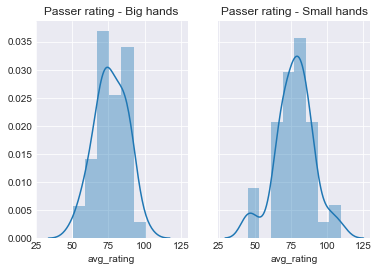

In [147]:
f, axes = plt.subplots(1,2, sharey=True, sharex=True)
sns.distplot(big_hands, ax=axes[0])
axes[0].set_title('Passer rating - Big hands')
sns.distplot(small_hands, ax=axes[1])
axes[1].set_title('Passer rating - Small hands')
plt.show()
# on first glance they look more or less the same

Because of the relatively small sample sizes we assume our distributions are of the students-t distribution (Kruschke).
The students-t has a mean, variance, and degree-of-freedom.
The degree of freedom control the normality of the data (larger dof converges to normal distribution).

Lets set up the model

In [ ]:
mu = pd.concat([small_hands,big_hands]).mean()
std = pd.concat([small_hands,big_hands]).std()